In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import torch
import numpy as np
import config as C
from convcnp_architectures import ConvCNP
from architectures import UNet, SimpleConv, DepthSepConv1d
import os
from datasets import HydroDataset, HydroTestDataset
from likelihoods import compute_logpdf
from run_training import unpickle_object
from transformations import rev_transform
import NSE
from task_utils import loaded_task
from plot_utils import plot_model_task, plot_task
import time 

%matplotlib inline

In [16]:
q_mu = unpickle_object('pickled/q_mu.pkl')
q_sigma = unpickle_object('pickled/q_sigma.pkl')
# dist = unpickle_object('pickled/dist.pkl')\
dist = "gaussian"

df_train = unpickle_object('pickled/train.pkl')
df_test_both = unpickle_object('pickled/test_both.pkl')
df_test_catchment = unpickle_object('pickled/test_catchment.pkl')
df_test_temporal = unpickle_object('pickled/test_temporal.pkl')
df_att = unpickle_object('pickled/df_att.pkl')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate ConvCNP
model = ConvCNP(in_channels = len(C.context_channels)-1,
                # rho=SimpleConv(),
                # rho=UNet(),
                rho=DepthSepConv1d(in_channels=C.rho_in_channels, conv_channels=64, num_layers=7, kernel_size=15),
                points_per_unit=C.points_per_unit,
                dynamic_feature_embedding=False,
                static_embedding_dims=C.static_embedding_dims,
                static_feature_embedding=C.static_feature_embedding,
                static_embedding_in_channels=C.static_embedding_in_channels,
                static_feature_missing_data=C.static_feature_missing_data,
                static_embedding_location=C.static_embedding_location,
                distribution=dist)    

model.num_params

29272

In [17]:
# Assign model to device
model.to(device)

ROOT_PATH = r'C:\Users\Sior AMD-4\repos\hydro-nps\_experiments/2024-05-29_15-18-47_forecasting-loggaussian'
model.load_state_dict(torch.load(os.path.join(ROOT_PATH, 'model_best.pth.tar')))

nses = []

# Instantiate data generator for testing.
NUM_TEST_TASKS = 256 # 128
gen_test = HydroDataset(
                        dataframe=df_test_both,
                        df_att = df_att,
                        batch_size = 32,
                        num_tasks = NUM_TEST_TASKS,
                        channels_c = C.context_channels,
                        channels_t = C.target_channels,
                        channels_att = C.attributes,
                        channels_t_val = C.target_val_channel,
                        context_mask = C.context_mask,
                        target_mask = C.target_mask,
                        extrapolate = True,
                        concat_static_features = C.concat_static_features,
                        timeslice = C.timeslice,
                        min_train_points = C.min_train_points,
                        min_test_points = C.min_test_points,
                        max_train_points = C.max_train_points,
                        max_test_points = C.max_test_points,
                        device = 'cpu',
                        return_basins=True,
                        )

dataloader = torch.utils.data.DataLoader(gen_test, batch_size=1, shuffle=False, num_workers=0)


In [19]:
nses = []
basins_nses = []
s = time.time()

for idx, (task,basins) in enumerate(dataloader):

    task = loaded_task(task=task)
    
    for i in range(gen_test.batch_size):
        if i > 10: break
        # plot_task(task, i, legend=True)
        nse = plot_model_task(model, task, gen_test.timeslice, i, legend=True, dist=dist, q_mu=q_mu, q_sigma=q_sigma, plot=False)
        nses.append(nse) 
        basins_nses.append(basins[i][0])
        print(basins[i][0], round(nse, 2))
   
    if time.time() - s > 30: 
        print('All done')
        break

10234500 -26.35
03050000 0.38
02216180 0.21
02028500 0.58
05466500 -0.59
09223000 -1.12
12383500 -15.94
08190500 0.45
09447800 -4.77
03460000 -0.22
05592575 0.18
01169000 0.59
04213075 0.28
12488500 -0.72
08200000 0.11
02299950 -0.39
01644000 -1.49
02055100 0.48
01144000 0.53
12144000 0.32
07359610 0.21
02216180 0.6
03592718 0.24
01594950 0.09
04213075 0.03
09447800 -1.25
09447800 -2.06
01532000 0.52
12144000 0.18
08200000 -1.32
09065500 0.65
05503800 -0.1
12114500 0.44
05592575 0.25
02096846 0.09
07362587 0.19
08171300 -5.36
02216180 0.04
02342933 0.12
02427250 0.63
12114500 0.5
01440400 0.29
12114500 0.43
08171300 0.04
04213075 0.14
05592575 0.28
05503800 0.35
05466500 -37.34
10234500 -1.24
08200000 0.74
03460000 0.5
03368000 -0.77
06477500 0.16
12488500 0.67
04221000 0.45
02427250 0.54
09065500 0.65
03460000 -0.54
02028500 0.29
01518862 0.33
01532000 0.51
09447800 0.08
03592718 0.33
09065500 0.67
07359610 0.28
05466500 -0.52
02055100 0.25
09223000 -0.51
01532000 0.21
09447800 -2.09


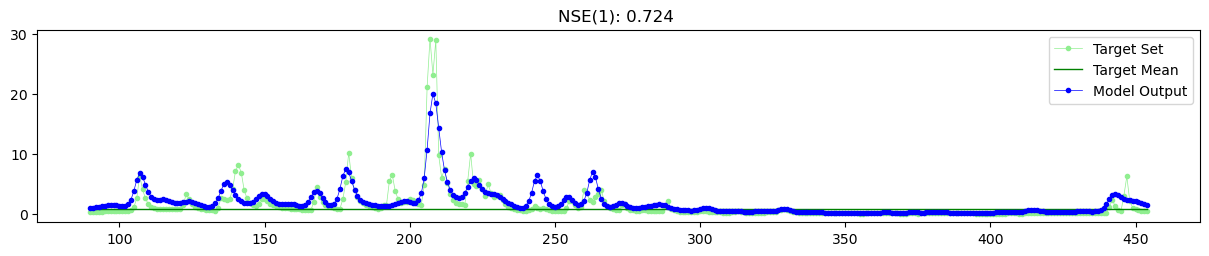

03281500 0.72


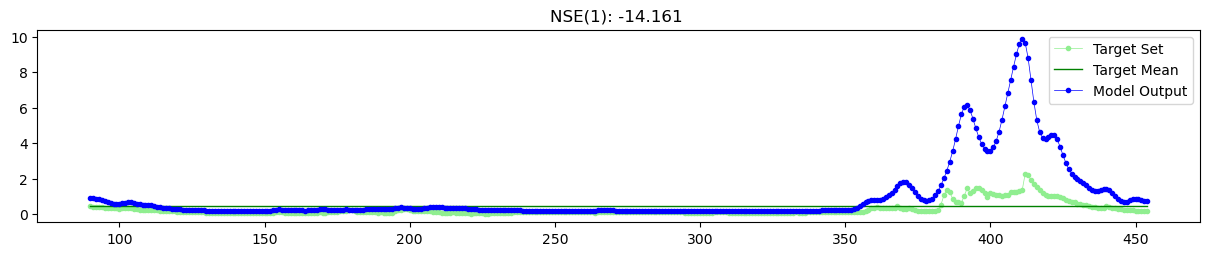

09223000 -14.16


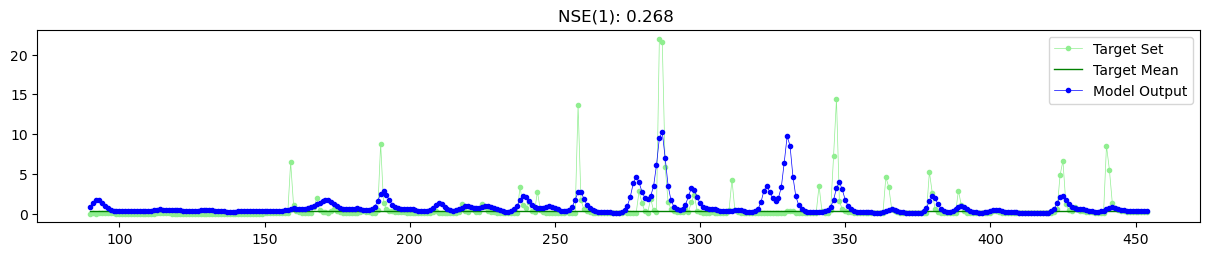

05592575 0.27


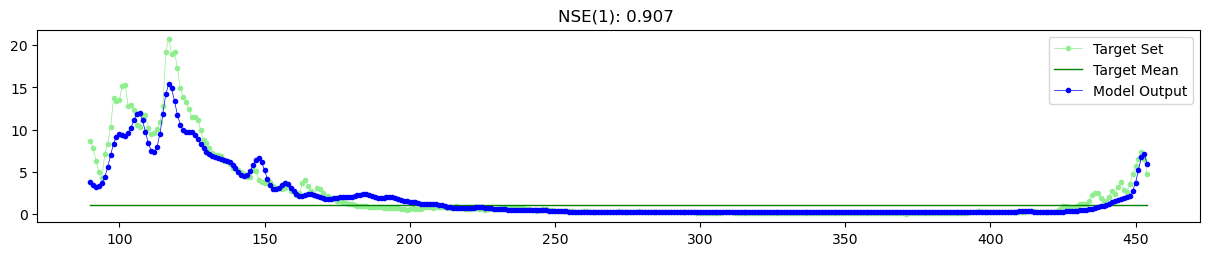

09065500 0.91


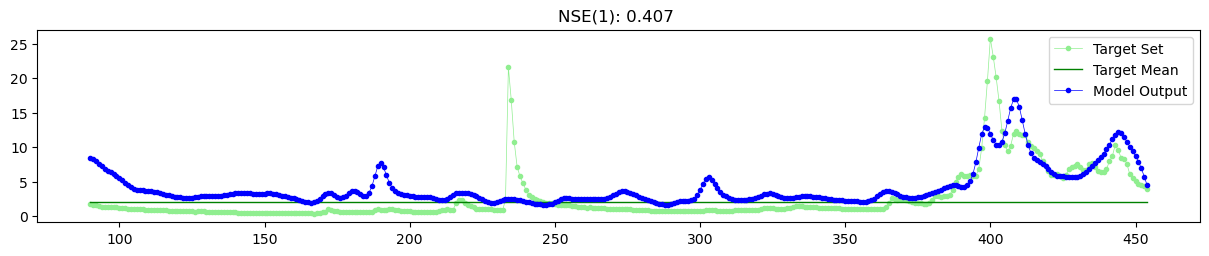

12488500 0.41


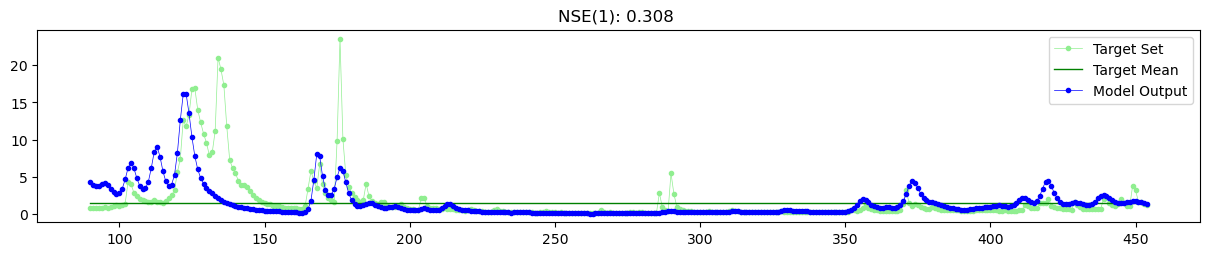

01169000 0.31


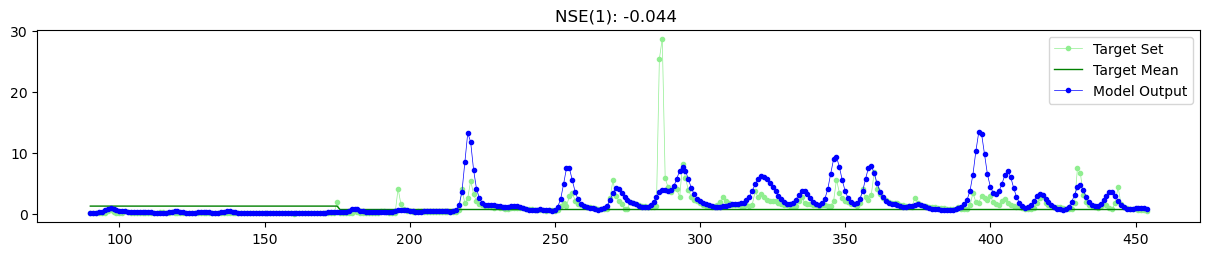

01594950 -0.04


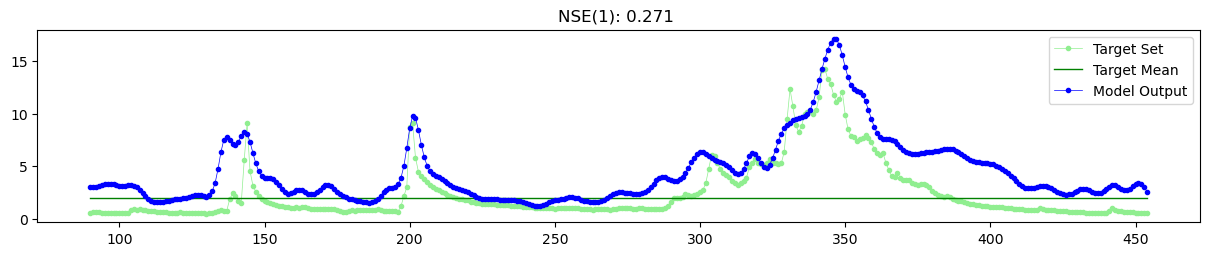

12488500 0.27


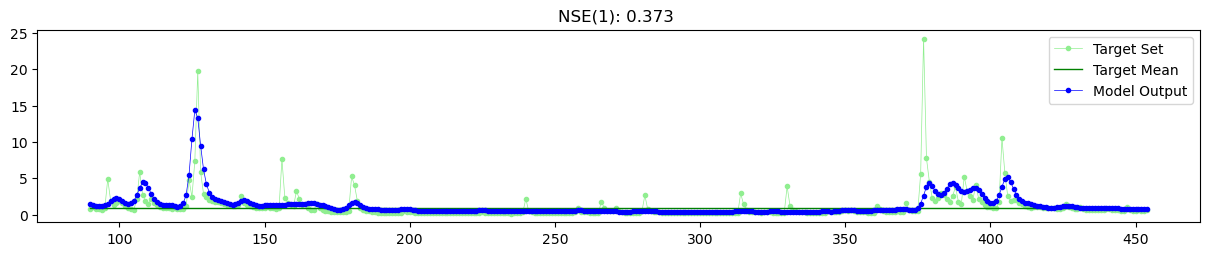

03592718 0.37


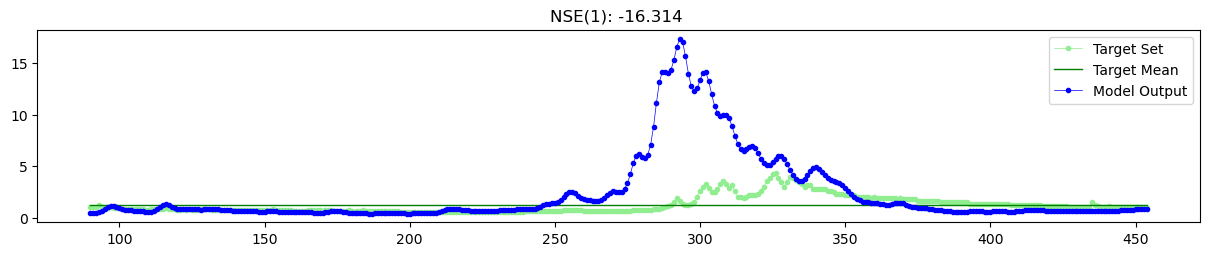

12383500 -16.31


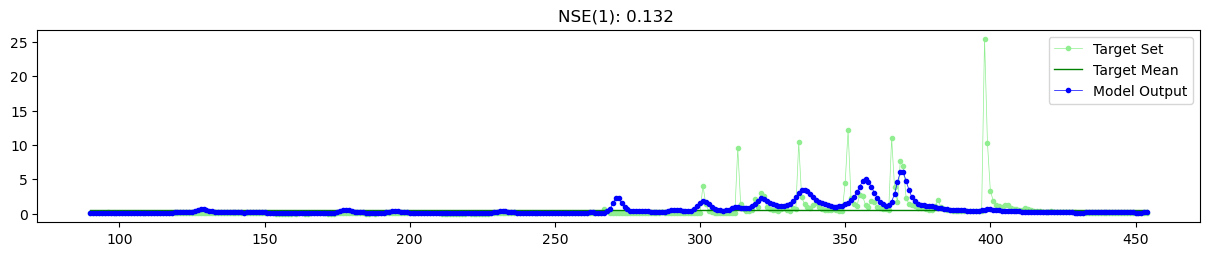

02342933 0.13


In [20]:
for idx, (task,basins) in enumerate(dataloader):

    task = loaded_task(task=task)
    
    for i in range(gen_test.batch_size):
        if i > 10: break
        # plot_task(task, i, legend=True)
        nse = plot_model_task(model, task, gen_test.timeslice, i, legend=True, dist=dist, q_mu=q_mu, q_sigma=q_sigma, plot=True)
        print(basins[i][0], round(nse, 2))

    # break
    if time.time() - s > 30: break

In [11]:
np.mean(nses), np.median(nses)

(-11.63977112378223, 0.17689082026481628)

In [9]:
# unique basins for negative NSE values

# get indices of negative NSE values
neg_nses = np.array(nses) < -1

# get number of negative NSE values
neg_nses_count = np.sum(neg_nses)

# get unique basins
unique_basins = np.unique(np.array(basins_nses)[neg_nses])

print(f'Number of negative NSE values: {neg_nses_count}')
print(f'Proportion of negative NSE values: {neg_nses_count / len(nses)*100}')
print(f'Number of unique basins: {len(unique_basins)}')
# unique lentgh of basins_nses
print(f'Number of unique basins in basins_nses: {len(np.unique(basins_nses))}')


Number of negative NSE values: 156
Proportion of negative NSE values: 17.29490022172949
Number of unique basins: 19
Number of unique basins in basins_nses: 44


In [20]:
unique_basins

array(['01518862', '02055100', '05466500', '06477500', '06479215',
       '06903400', '08171300', '08190500', '08200000', '09223000',
       '09306242', '09447800', '10234500', '12383500', '12488500'],
      dtype='<U8')

In [ ]:
df_test_both.loc[df_test_both['basin'].isin(unique_basins)]

# plot flow for each of the basins
for basin in unique_basins:
    df_test_both.loc[df_test_both['basin'] == basin].plot(y='QObs(mm/d)', title=f'Basin {basin}', figsize=(10, 3))

# df_test_both.loc[df_test_both['basin'] == unique_basins[0]].plot(y='QObs(mm/d)', title=f'Basin {unique_basins[0]}')


In [11]:
df_test_both

,Year,Mnth,Day,Hr,Dayl(s),PRCP(mm/day),SRAD(W/m2),SWE(mm),Tmax(C),Tmin(C),Vp(Pa),QObs(mm/d),basin,QObs(mm/d)_mean
0,-0.215432,10,1,12,-0.292692,-0.701371,0.314356,NaN,0.104785,-0.235703,-0.359591,-0.619337,01144000,0.414623
1,-0.215432,10,2,12,-0.292692,-0.632712,-0.312805,NaN,0.429908,-0.003634,-0.022630,-0.633230,01144000,0.414623
2,-0.215432,10,3,12,-0.341070,-0.661570,0.263364,NaN,0.067880,0.207698,0.108127,-0.657850,01144000,0.414623
3,-0.215432,10,4,12,-0.341070,2.488358,-1.721184,NaN,0.081060,0.291638,0.434539,-0.631486,01144000,0.414623
4,-0.215432,10,5,12,-0.389448,0.702865,-1.008368,NaN,-0.039323,0.340026,0.494466,-0.215932,01144000,0.414623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241071,1.294439,9,26,12,-0.147556,0.572796,-0.792304,NaN,0.012521,0.035868,-0.138915,-0.002237,12488500,0.754976
241072,1.294439,9,27,12,-0.195935,-0.381909,0.195887,NaN,0.195292,0.019080,0.031123,-0.022573,12488500,0.754976
241073,1.294439,9,28,12,-0.196957,-0.338412,0.164922,NaN,0.145206,0.234361,0.188049,-0.043183,12488500,0.754976
241074,1.294439,9,29,12,-0.244313,0.572796,0.254197,NaN,0.114451,-0.250516,-0.164107,-0.064075,12488500,0.754976


In [12]:
# ratio of negative NSE values
np.sum(np.array(nses) < 0) / len(nses)

# mean NSE for non-negative values
np.mean([nse for nse in nses if nse >= 0]), np.median([nse for nse in nses if nse >= 0])

(0.3677915262717467, 0.3592088222503662)

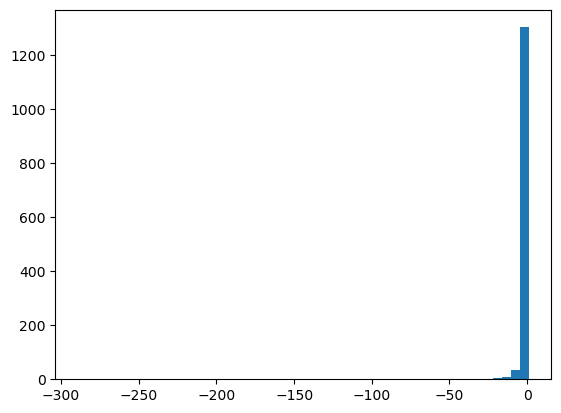

In [44]:
import matplotlib.pyplot as plt
plt.hist(nses, bins=50)
plt.show()

In [104]:
# number unique basins in dataframes
print(len(df_train['basin'].unique()))
print(len(df_test_both['basin'].unique()))
print(len(df_test_catchment['basin'].unique()))
print(len(df_test_temporal['basin'].unique()))


487
44
44
487


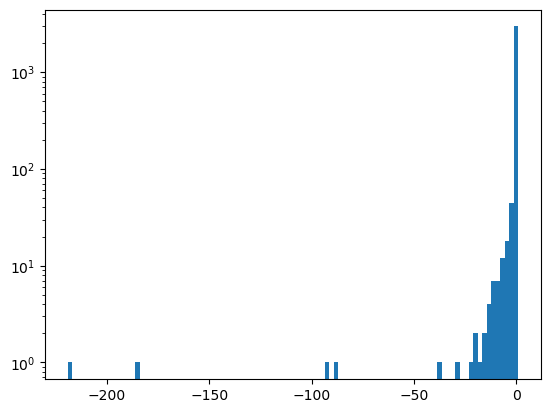

-0.07858710813040186
-219.21636962890625
0.9730524979531765
0.32608887553215027
0.3578771650541149
0.3470023274421692


In [47]:
# hist with y log scale
plt.hist(nses, bins=100, log=True)
plt.show()


print(np.mean(nses))
# print(np.std(nses))
print(np.min(nses))
print(np.max(nses))
print(np.median(nses))

# mean ignoring negative values
print(np.mean([nse for nse in nses if nse > 0]))

# meadian ignoring negative values
print(np.median([nse for nse in nses if nse > 0]))

In [40]:
import matplotlib.pyplot as plt